In [5]:
import pandas as pd
import numpy as np
import requests
import json
import time
import pickle
from dateutil import relativedelta
import seaborn as sns

### API call for redcap

In [6]:
def api_call(url, query, logger=None):
    """ helper function to make API calls to RedCap
    """
    r = requests.post(url, data=query, verify=False)
    http_status = str(r.status_code)
    print(f'HTTP Status: {http_status}')

    if http_status == "200":
        query_results = r.json()
        query_df = pd.DataFrame(query_results)

    else:
        print(f"RedCap API request Failed with HTTP Status: {http_status}")
        query_df = None
        
    return query_df

def get_inventory_count(df, index_col, availability_indicators):
    """ helper function to count participants with recorded data in redcap
    """
    assess_cols = df.columns.drop(index_col)

    if availability_indicators == 'number':
        df = df.replace("", np.nan)
        df[assess_cols] = df[assess_cols].astype(np.float64)

    inventory = {}
    for col in assess_cols:        
        if availability_indicators == 'number':
            availability_count = df[~df[col].isna()][index_col].nunique()
        else:
            availability_count = df[df[col].isin(availability_indicators)][index_col].nunique()
        inventory[col] = availability_count
    return inventory

def get_available_data(config_json, DATASET_ROOT, var_name, preferred_var_source="primary"):
    """ Get data for given variables from available sources
        All return dataframes should have participant_id and visit_id as index
    """
    config_data = json.load(open(config_json))
    data_sources = config_data['data_sources']
    variable_info = config_data['variables'][var_name]
    variable_type = variable_info["type"]
    variable_sources = variable_info["sources"]

    if preferred_var_source == "primary":
        selected_var_source = variable_info['primary_source']
        selected_var_instrument = variable_info['primary_instrument']
    elif preferred_var_source == "secondary":
        selected_var_source = variable_info['secondary_source']
        selected_var_instrument = variable_info['secondary_instrument']
    else:
        print(f"Using preferred source {preferred_var_source} for variable {var_name}")
        preferred_var_data_source = preferred_var_source["data_source"]
        preferred_var_instrument = preferred_var_source["instrument"]

        if preferred_var_data_source not in variable_sources.keys():
            print(f"Preferred data source {preferred_var_data_source} not available for variable {var_name}")
            return None
        else:
            selected_var_source = preferred_var_data_source

        if preferred_var_instrument not in variable_sources[selected_var_source].keys():
            print(f"Preferred var instrument {preferred_var_instrument} not available for variable {var_name}")
            return None
        else:
            selected_var_instrument = preferred_var_instrument

    print(f"Using variable {var_name} from source {selected_var_source} and instrument {selected_var_instrument}")

    external_var_cols = variable_sources[selected_var_source][selected_var_instrument]

    # Get data from primary source
    var_file = data_sources[selected_var_source][selected_var_instrument]["path"]
    var_file_path = f"{DATASET_ROOT}/{var_file}"
    var_file_index = data_sources[selected_var_source][selected_var_instrument]["index_cols"]

    var_df = pd.read_csv(var_file_path)
    selected_var_cols = list(set(var_file_index + external_var_cols))
    var_df = var_df[selected_var_cols]
    
    if (variable_type == "date") & (len(external_var_cols) == 1):
        var_df[external_var_cols[0]] = pd.to_datetime(var_df[external_var_cols[0]], errors="coerce", dayfirst=False)

    if (len(external_var_cols) == 1):
        var_df = var_df.rename(columns={external_var_cols[0]:var_name})
    
    return var_df


### Paths


In [7]:
DATASET_ROOT = "/home/nikhil/projects/Parkinsons/qpn/"

# Current nipoppy manifest
release_dir = f"{DATASET_ROOT}/releases/"
current_release = "June_2024"

tabular_data_release_dir = f"{release_dir}/{current_release}/"

demo_config_json = "../workflow/tabular/demographics.json"
pheno_config_json = "../workflow/tabular/pheno.json"


### Standardized index names

In [8]:
baseline_event_name = "Baseline (Arm 1: C-OPN)"

## redcap event name variations
config_data = json.load(open(demo_config_json))
data_sources = config_data['data_sources']
redcap_data_sources = data_sources['redcap']

redcap_field_name_map = {}

for instrument in redcap_data_sources.keys():
    index_cols = redcap_data_sources[instrument]['index_cols']
    record_id = index_cols[0]
    event_name = index_cols[1]

    redcap_field_name_map[record_id] = "participant_id"
    redcap_field_name_map[event_name] = "redcap_event_name"
print(f"redcap_field_name_map: {redcap_field_name_map}")

# legacy participant_id variations in DOB and BD_RPQ
legacy_field_name_map = {}
legacy_field_name_map['Record ID'] = "participant_id"
legacy_field_name_map['Patient #'] = "participant_id"
legacy_field_name_map['Name of visit (V01, V02, V03)'] = "visit"
print(f"legacy_field_name_map: {legacy_field_name_map}")

redcap_field_name_map: {'Record ID:': 'participant_id', 'Event Name': 'redcap_event_name', 'record_id': 'participant_id', 'redcap_event_name': 'redcap_event_name'}
legacy_field_name_map: {'Record ID': 'participant_id', 'Patient #': 'participant_id', 'Name of visit (V01, V02, V03)': 'visit'}


### Update RedCAP reports through API 
(Not updating extended report since it has to come from Sarah)
- "global_records_query"
- "QPN MoCA-UPDRS-Neuropsy data_Sarah"

In [9]:
update_redcap_reports = False

redcap_report_list = ["global_records_query", "QPN MoCA-UPDRS-Neuropsy data_Sarah"]
if update_redcap_reports:
    redcap_config_json = f"{DATASET_ROOT}/proc/.redcap.json"
    redcap_config = json.load(open(redcap_config_json))
    url = redcap_config["url"]
    
    for redcap_report in redcap_report_list:
        print(f"Getting data for RedCap report: {redcap_report}")
        records_query = redcap_config["queries"][redcap_report]
        query_df = api_call(url, records_query, logger=None)
        report_csv = f"{release_dir}{current_release}/tabular/redcap/{redcap_report}.csv"
        query_df.to_csv(report_csv, index=False)
        print(f"Saved RedCap report to {report_csv}")



### Available participants

In [10]:
QPN_participants_df = get_available_data(demo_config_json,tabular_data_release_dir,"participant_id")
QPN_participants = QPN_participants_df["participant_id"].unique()
n_participants = len(QPN_participants)
print(f"Number of participants: {n_participants}")

Using variable participant_id from source local and instrument manifest
Number of participants: 306


### Fetch demographic data

In [11]:
demo_vars = ["dob", "group", "sex", "education"]
# preferred_var_source = {"data_source":"local","instrument":"legacy_DOB"}
vars_with_secondary_source = ["dob"]

config_json = demo_config_json
index_cols = ["participant_id", "redcap_event_name"]

demo_var_df = pd.DataFrame()
for var in demo_vars:
    _df = get_available_data(config_json,tabular_data_release_dir,var)
    _df = _df.rename(columns=redcap_field_name_map)
    _df = _df.rename(columns=legacy_field_name_map)
    _df = _df[_df["participant_id"].isin(QPN_participants)].copy()

    if var in vars_with_secondary_source:
        print(f"**Getting data from the secondary source for variable {var}**")
        _df2 = get_available_data(config_json,tabular_data_release_dir,var,preferred_var_source="secondary")
        _df2 = _df2.rename(columns=legacy_field_name_map)
        _df2 = _df2.rename(columns={var:var+"_secondary"})
        _df2 = _df2[_df2["participant_id"].isin(QPN_participants)].copy()
        
        # Merge primary and secondary sources
        n_missing_in_primary = _df[_df["redcap_event_name"]==baseline_event_name][var].isna().sum()
        print(f"Missing data in primary source: {n_missing_in_primary}")

        if "redcap_event_name" in _df2.columns:
            _df = pd.merge(_df, _df2, on=["participant_id","redcap_event_name"], how="outer")
        else:
            _df = pd.merge(_df, _df2, on="participant_id", how="outer")
        _df[var] = _df[var].fillna(_df[var+"_secondary"])
        # _df = _df.drop(columns=[var+"_secondary"])

        n_missing_after_secondary_fill = _df[_df["redcap_event_name"]==baseline_event_name][var].isna().sum()
        print(f"Missing data after secondary source fill: {n_missing_after_secondary_fill}")

    if demo_var_df.empty:
        demo_var_df = _df
    else:
        demo_var_df = pd.merge(demo_var_df, _df, on=index_cols, how="outer")   

demo_participants = demo_var_df["participant_id"].unique()
n_demo_participants = len(demo_participants)
print('-'*50)
print(f"Number of participants with demographics data: {n_demo_participants}")
print('-'*50)

demo_redcap_events = demo_var_df["redcap_event_name"].unique()
print(f"Demographics data available for events: {demo_redcap_events}")
print('-'*50)

for var in demo_vars:
    n_unique = demo_var_df[demo_var_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"][var].nunique()
    n_missing = demo_var_df[demo_var_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"][var].isna().sum()
    print(f"Var: {var}, n_unique: {n_unique}, n_missing: {n_missing} (out of {n_demo_participants})")

demo_var_df.head()

Using variable dob from source redcap and instrument sarah_extended_export
**Getting data from the secondary source for variable dob**
Using variable dob from source local and instrument legacy_DOB
Missing data in primary source: 12
Missing data after secondary source fill: 1
Using variable group from source redcap and instrument sarah_extended_export
Using variable sex from source redcap and instrument sarah_extended_export
Using variable education from source redcap and instrument sarah_extended_export
--------------------------------------------------
Number of participants with demographics data: 299
--------------------------------------------------
Demographics data available for events: ['Baseline (Arm 1: C-OPN)' '18 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '72 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '36 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '54 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '24 Months Follow-Up/Suivi (Arm 1: C-OPN)' nan]
--

,participant_id,dob,redcap_event_name,dob_secondary,group,sex,education
0,MNI0028,1963-07-27,Baseline (Arm 1: C-OPN),NaT,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,NaN
1,MNI0056,1942-05-21,Baseline (Arm 1: C-OPN),NaT,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,NaN
2,MNI0058,1964-03-14,Baseline (Arm 1: C-OPN),NaT,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,NaN
3,MNI0068,1952-05-08,Baseline (Arm 1: C-OPN),NaT,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,NaN
4,MNI0079,1971-11-25,Baseline (Arm 1: C-OPN),NaT,PD (Parkinson's Disease)/Maladie de Parkinson,Female/Féminin,NaN


### Find records with phenotypic data

In [12]:
var = "updrs_scores"
updrs_df = get_available_data(config_json,tabular_data_release_dir,var)
updrs_df = updrs_df.rename(columns=redcap_field_name_map)
updrs_df = updrs_df.rename(columns=legacy_field_name_map)
updrs_df = updrs_df[updrs_df["participant_id"].isin(QPN_participants)].copy()
updrs_df = updrs_df[updrs_df["redcap_event_name"]==baseline_event_name].copy()

participant_updrs = updrs_df["participant_id"].unique()
n_participant_updrs = len(participant_updrs)
print(f"Number of participants with UPDRS data: {n_participant_updrs}")


for var in pheno_var_df.columns:
    if var not in index_cols:
        n_avail = updrs_df[updrs_df["redcap_event_name"]==baseline_event_name][var].notna().sum()
        n_missing = updrs_df[updrs_df["redcap_event_name"]==baseline_event_name][var].isna().sum()

        print(f"{var} data available for {n_avail} participants, missing for {n_missing} participants")


KeyError: 'updrs_scores'

### Previous report: number of participants with UPDRS data: 294
- UPDRS data available for 157 participants, missing for 137 participants
- UPDRS data available for 155 participants, missing for 139 participants
- UPDRS data available for 156 participants, missing for 138 participants
- UPDRS data available for 157 participants, missing for 137 participants
- UPDRS data available for 155 participants, missing for 139 participants

In [25]:
pheno_vars = ["diagnosis", "updrs_scores", "moca_scores", "diagnosis_date", "updrs_date", "moca_date"]
# preferred_var_source = {"data_source":"local","instrument":"legacy_DOB"}

config_json = pheno_config_json
index_cols = ["participant_id", "redcap_event_name"]
pheno_var_df = pd.DataFrame()
for var in pheno_vars:
    _df = get_available_data(config_json,tabular_data_release_dir,var)
    _df = _df.rename(columns=redcap_field_name_map)
    _df = _df.rename(columns=legacy_field_name_map)
    _df = _df[_df["participant_id"].isin(QPN_participants)].copy()
    if pheno_var_df.empty:
        pheno_var_df = _df
    else:
        pheno_var_df = pd.merge(pheno_var_df, _df, on=index_cols, how="outer")   

pheno_participants = pheno_var_df["participant_id"].unique()
n_pheno_participants = len(pheno_participants)
print('-'*50)
print(f"Number of participants with pheno data: {n_pheno_participants}")
print('-'*50)

pheno_redcap_events = pheno_var_df["redcap_event_name"].unique()
print(f"Pheno data available for events: {pheno_redcap_events}")
print('-'*50)

for var in pheno_var_df.columns:
    for redcap_event in pheno_redcap_events:
        if var not in index_cols:
            pheno_var_event_df = pheno_var_df[pheno_var_df["redcap_event_name"]==redcap_event].copy()
            n_pheno_var_event_participants = pheno_var_event_df["participant_id"].nunique()
            if pheno_var_event_df[var].nunique() > 0:    
                print(f"Var: {var}, Event: {redcap_event}")
                n_unique = pheno_var_event_df[var].nunique()
                n_missing = pheno_var_event_df[var].isna().sum()
                print(f"n_unique: {n_unique}, n_missing: {n_missing} (out of {n_pheno_var_event_participants})")
    print('-'*50)

pheno_var_df.head()

Using variable diagnosis from source redcap and instrument sarah_extended_export
Using variable updrs_scores from source redcap and instrument sarah_extended_export
Using variable moca_scores from source redcap and instrument sarah_extended_export
Using variable diagnosis_date from source redcap and instrument sarah_extended_export
Using variable updrs_date from source redcap and instrument sarah_extended_export
Using variable moca_date from source redcap and instrument sarah_extended_export
--------------------------------------------------
Number of participants with pheno data: 294
--------------------------------------------------
Pheno data available for events: ['Baseline (Arm 1: C-OPN)' '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '18 Months Follow-Up/Suivi (Arm 1: C-OPN)']
--------------------------------------------------
--------------------------------------------------
Var: diagnosis, Event: Baseline (Arm 1: C-OPN)
n_unique: 5, n_missing: 101 (out of 294)
-------------------

,participant_id,diagnosis,redcap_event_name,Part III: Motor Examination,Hoehn and Yahr Stage:,Part IV: Motor Complications,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),moca_scores,diagnosis_date,updrs_date,moca_date
0,MNI0028,0.0,Baseline (Arm 1: C-OPN),29.0,(2) Bilateral involvement without impairment o...,0.0,0.0,2.0,28.0,2020-09-13,2023-10-04,2023-10-04
1,MNI0028,NaN,12 Months Follow-Up/Suivi (Arm 1: C-OPN),NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT
2,MNI0028,NaN,18 Months Follow-Up/Suivi (Arm 1: C-OPN),NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT
3,MNI0056,0.0,Baseline (Arm 1: C-OPN),58.0,(3) Bilateral disease: mild to moderate disabi...,0.0,12.0,22.0,22.0,2017-09-01,2021-06-11,2021-06-11
4,MNI0056,NaN,12 Months Follow-Up/Suivi (Arm 1: C-OPN),NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT


### Add mri_acq date
- Needs to map to redcap_event_name

In [26]:
var = "MRI_date"
config_json = pheno_config_json
mri_date_df = get_available_data(config_json,tabular_data_release_dir,var)
mri_date_df["MRI_date"] = pd.to_datetime(mri_date_df["MRI_date"], errors="coerce", dayfirst=False)

n_mri_participants = mri_date_df["participant_id"].nunique()
print(f"Number of participants with MRI data: {n_mri_participants}")

n_sessions = mri_date_df["session"].nunique()
print(f"Number of MRI sessions: {n_sessions}")

participants_with_follow_ups = mri_date_df[mri_date_df["participant_id"].duplicated()]["participant_id"].unique()
n_participants_with_follow_ups = len(participants_with_follow_ups)
print(f"Number of participants with follow-up MRI: {n_participants_with_follow_ups}")

mri_ses01_date_df = mri_date_df[mri_date_df["session"]=="ses-01"].copy()
mri_ses01_date_df["redcap_event_name"] = "Baseline (Arm 1: C-OPN)"

mri_ses02_date_df = mri_date_df[mri_date_df["session"]=="ses-02"].copy()
mri_ses02_participants = mri_ses02_date_df["participant_id"].unique()
print(f"Number of participants with ses-02 MRI: {len(mri_ses02_participants)}")

baseline_df = mri_ses01_date_df[mri_ses01_date_df["participant_id"].isin(mri_ses02_participants)].set_index("participant_id")
followup_df = mri_ses02_date_df.set_index("participant_id")

visit_months = [12, 18, 24, 30, 36, 42, 48, 54]
month_bins = [9, 15, 21, 27, 33, 39, 45, 51, 57]

event_str_suffix = "Months Follow-Up/Suivi (Arm 1: C-OPN)"
event_names = [f"{m} {event_str_suffix}" for m in visit_months]

# --- Bin the months --- #
followup_df["months_since_baseline"] = followup_df["MRI_date"].dt.to_period('M').astype(int) - baseline_df["MRI_date"].dt.to_period('M').astype(int)
followup_df["months_since_baseline"] = followup_df["months_since_baseline"].replace({0:np.nan}) # Some visits get same acq_date from brodacasting merge. 

followup_df["redcap_event_name"] = pd.cut(followup_df["months_since_baseline"], bins=month_bins, labels=event_names)

mri_date_redcap_event_df = pd.concat([mri_ses01_date_df, followup_df.reset_index()], axis=0)
# mri_date_redcap_event_df = mri_date_redcap_event_df

mri_date_redcap_event_df.sort_values(["participant_id","session"]).head()

Using variable MRI_date from source local and instrument MRI_dates
Number of participants with MRI data: 298
Number of MRI sessions: 2
Number of participants with follow-up MRI: 51
Number of participants with ses-02 MRI: 51


,MRI_date,session,participant_id,redcap_event_name,months_since_baseline
0,2023-10-04,ses-01,MNI0028,Baseline (Arm 1: C-OPN),NaN
1,2021-08-18,ses-01,MNI0056,Baseline (Arm 1: C-OPN),NaN
2,2021-08-18,ses-01,MNI0058,Baseline (Arm 1: C-OPN),NaN
3,2021-08-27,ses-01,MNI0068,Baseline (Arm 1: C-OPN),NaN
4,2021-12-22,ses-01,MNI0079,Baseline (Arm 1: C-OPN),NaN


#### Add MRI date to pheno data

In [27]:
pheno_var_df = pd.merge(pheno_var_df, mri_date_redcap_event_df, on=index_cols, how="right")  
var = "MRI_date"
for redcap_event in mri_date_redcap_event_df["redcap_event_name"].unique():    
    pheno_var_event_df = pheno_var_df[pheno_var_df["redcap_event_name"]==redcap_event].copy()
    n_pheno_var_event_participants = pheno_var_event_df["participant_id"].nunique()
    if pheno_var_event_df[var].nunique() > 0:    
        print(f"Var: {var}, Event: {redcap_event}")
        n_unique = pheno_var_event_df[var].nunique()
        n_missing = pheno_var_event_df[var].isna().sum()
        print(f"n_unique: {n_unique}, n_missing: {n_missing} (out of {n_pheno_var_event_participants})")
pheno_var_df.head()

Var: MRI_date, Event: Baseline (Arm 1: C-OPN)
n_unique: 234, n_missing: 0 (out of 298)
Var: MRI_date, Event: 12 Months Follow-Up/Suivi (Arm 1: C-OPN)
n_unique: 27, n_missing: 0 (out of 30)
Var: MRI_date, Event: 18 Months Follow-Up/Suivi (Arm 1: C-OPN)
n_unique: 8, n_missing: 0 (out of 9)
Var: MRI_date, Event: 48 Months Follow-Up/Suivi (Arm 1: C-OPN)
n_unique: 1, n_missing: 0 (out of 1)
Var: MRI_date, Event: 42 Months Follow-Up/Suivi (Arm 1: C-OPN)
n_unique: 2, n_missing: 0 (out of 2)
Var: MRI_date, Event: 36 Months Follow-Up/Suivi (Arm 1: C-OPN)
n_unique: 1, n_missing: 0 (out of 1)
Var: MRI_date, Event: 30 Months Follow-Up/Suivi (Arm 1: C-OPN)
n_unique: 1, n_missing: 0 (out of 1)


,participant_id,diagnosis,redcap_event_name,Part III: Motor Examination,Hoehn and Yahr Stage:,Part IV: Motor Complications,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),moca_scores,diagnosis_date,updrs_date,moca_date,MRI_date,session,months_since_baseline
0,MNI0028,0.0,Baseline (Arm 1: C-OPN),29.0,(2) Bilateral involvement without impairment o...,0.0,0.0,2.0,28.0,2020-09-13,2023-10-04,2023-10-04,2023-10-04,ses-01,NaN
1,MNI0056,0.0,Baseline (Arm 1: C-OPN),58.0,(3) Bilateral disease: mild to moderate disabi...,0.0,12.0,22.0,22.0,2017-09-01,2021-06-11,2021-06-11,2021-08-18,ses-01,NaN
2,MNI0058,0.0,Baseline (Arm 1: C-OPN),26.0,"(1) Unilateral involvement only, usually with ...",0.0,0.0,6.0,25.0,2020-05-22,2021-07-23,2021-07-23,2021-08-18,ses-01,NaN
3,MNI0068,0.0,Baseline (Arm 1: C-OPN),28.0,(2) Bilateral involvement without impairment o...,0.0,11.0,8.0,NaN,2014-01-01,2021-08-27,NaT,2021-08-27,ses-01,NaN
4,MNI0079,0.0,Baseline (Arm 1: C-OPN),22.0,(2) Bilateral involvement without impairment o...,8.0,13.0,10.0,26.0,2017-05-01,2022-01-21,2021-12-22,2021-12-22,ses-01,NaN


### Neuropsych data
- Comes from either from Sarah's extended report or BD_RPQ_UPDATE_Neuropsy

In [28]:
neuropsych_vars = ["neuropsy_scores","neuropsy_date"]

config_data = json.load(open(config_json))
variable_info = config_data['variables'][neuropsych_vars[0]]
variable_sources = variable_info["sources"]
neuropsy_source = variable_info['primary_source']

print(f"Using neuropsych data source: {neuropsy_source}")
# local BD_RPQ data
if neuropsy_source == "local":
    index_cols = ["participant_id", "visit", "TimePoint (based on REDCap; baseline, 18m, 36m, etc.)", "Délai depuis baseline (mois)"]
    
# redcap data
if neuropsy_source == "redcap":
    index_cols = ["participant_id", "redcap_event_name"]

    
neuropsych_df = pd.DataFrame()
for var in neuropsych_vars:
    _df = get_available_data(config_json,tabular_data_release_dir,var)
    _df = _df.rename(columns=redcap_field_name_map)
    _df = _df.rename(columns=legacy_field_name_map)
    _df = _df[_df["participant_id"].isin(QPN_participants)].copy()
    if neuropsych_df.empty:
        neuropsych_df = _df
    else:
        neuropsych_df = pd.merge(neuropsych_df, _df, on=index_cols, how="left")   

neuropsych_participants = neuropsych_df["participant_id"].unique()
n_neuropsych_participants = len(neuropsych_participants)
print('-'*50)
print(f"Number of participants with neuropysch data: {n_neuropsych_participants}")
print('-'*50)

# BD_RPQ data
if neuropsy_source == "local":
    neuropsych_visits = neuropsych_df["visit"].unique()

# REDCap data
if neuropsy_source == "redcap":
    neuropsych_visits = neuropsych_df["redcap_event_name"].unique()

print(f"neuropsych data available for events: {neuropsych_visits}")
print('-'*50)

neuropsych_df.head()

Using neuropsych data source: redcap
Using variable neuropsy_scores from source redcap and instrument sarah_extended_export
Using variable neuropsy_date from source redcap and instrument sarah_extended_export
--------------------------------------------------
Number of participants with neuropysch data: 294
--------------------------------------------------
neuropsych data available for events: ['Baseline (Arm 1: C-OPN)' '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '18 Months Follow-Up/Suivi (Arm 1: C-OPN)']
--------------------------------------------------


,Digit Span Backward - total correct (Raw score),BNT sans indice (Raw score),Was the Semantic Fluency test administered?,Letter Fluency A (Raw score),Semantic Fluency Animals (Raw score),Trial 2 raw,Trail B raw score (time in sec.),Main non dominante (30 sec),Semantic Fluency Actions (Raw score),Letter Fluency Total (Automatic Calculation),...,Stroop - D-Kefs - Cond.3: Total errors (Raw score),STROOP GOLDEN : COLORS Number of responses,"STROOP GOLDEN, words, uncorrected errors (raw score)",Stroop - D-Kefs - Cond.3: Uncorrected errors (Raw score),Brixton raw score,"STROOP GOLDEN : words, self-corrected errors (raw score)",Was the Purdue pegboard administered?,"Stroop GOLDEN, ink, uncorrected errors (raw score)",Stroop - D-Kefs - Cond.3: Total errors (Automatic calculation),neuropsy_date
0,7.0,36.0,"Yes, completed",6.0,16.0,9.0,86.0,8.0,17.0,40.0,...,0.0,NaN,NaN,0.0,13.0,NaN,"Yes, completed",NaN,0.0,2023-10-03
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,6.0,49.0,"Yes, completed",4.0,12.0,4.0,231.0,997.0,8.0,17.0,...,4.0,997.0,997.0,2.0,30.0,997.0,Missing Data,997.0,4.0,2021-07-30
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


### Basic clean-up and data checks

In [29]:
# Fix dtypes
if neuropsy_source == "local":
    for series_name, series in neuropsych_df.items():
        if "score" in series_name:
            if series.dtype == 'object':
                print(f"recasting {series_name} to float by replacing , with .")
                neuropsych_df[series_name] = neuropsych_df[series_name].str.replace(",",".").astype(float)
                neuropsych_df.loc[neuropsych_df[series_name]>900, series_name] = np.nan
                
        # Replace >900 with NaNs
        if series.dtype == 'float':
            neuropsych_df.loc[neuropsych_df[series_name]>900, series_name] = np.nan

    # assign redcap_event_name
    visit_months = [12, 18, 24, 30, 36, 42, 48, 54]
    month_bins = [9, 15, 21, 27, 33, 39, 45, 51, 57]
    event_str_suffix = "Months Follow-Up/Suivi (Arm 1: C-OPN)"
    event_names = [f"{m} {event_str_suffix}" for m in visit_months]

    neuropsych_df["redcap_event_name"] = pd.cut(neuropsych_df["Délai depuis baseline (mois)"], bins=month_bins, labels=event_names).astype(str)
    neuropsych_df.loc[neuropsych_df["TimePoint (based on REDCap; baseline, 18m, 36m, etc.)"]=="baseline", 
                      "redcap_event_name"] = "Baseline (Arm 1: C-OPN)"

# Merge with pheno_var_df
index_cols = ["participant_id", "redcap_event_name"]
pheno_var_df = pd.merge(pheno_var_df, neuropsych_df, on=index_cols, how="left")  

pheno_var_df.head()

,participant_id,diagnosis,redcap_event_name,Part III: Motor Examination,Hoehn and Yahr Stage:,Part IV: Motor Complications,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),moca_scores,diagnosis_date,...,Stroop - D-Kefs - Cond.3: Total errors (Raw score),STROOP GOLDEN : COLORS Number of responses,"STROOP GOLDEN, words, uncorrected errors (raw score)",Stroop - D-Kefs - Cond.3: Uncorrected errors (Raw score),Brixton raw score,"STROOP GOLDEN : words, self-corrected errors (raw score)",Was the Purdue pegboard administered?,"Stroop GOLDEN, ink, uncorrected errors (raw score)",Stroop - D-Kefs - Cond.3: Total errors (Automatic calculation),neuropsy_date
0,MNI0028,0.0,Baseline (Arm 1: C-OPN),29.0,(2) Bilateral involvement without impairment o...,0.0,0.0,2.0,28.0,2020-09-13,...,0.0,NaN,NaN,0.0,13.0,NaN,"Yes, completed",NaN,0.0,2023-10-03
1,MNI0056,0.0,Baseline (Arm 1: C-OPN),58.0,(3) Bilateral disease: mild to moderate disabi...,0.0,12.0,22.0,22.0,2017-09-01,...,4.0,997.0,997.0,2.0,30.0,997.0,Missing Data,997.0,4.0,2021-07-30
2,MNI0058,0.0,Baseline (Arm 1: C-OPN),26.0,"(1) Unilateral involvement only, usually with ...",0.0,0.0,6.0,25.0,2020-05-22,...,7.0,997.0,997.0,1.0,16.0,997.0,Missing Data,997.0,7.0,2021-08-18
3,MNI0068,0.0,Baseline (Arm 1: C-OPN),28.0,(2) Bilateral involvement without impairment o...,0.0,11.0,8.0,NaN,2014-01-01,...,0.0,997.0,997.0,0.0,11.0,997.0,Missing Data,997.0,0.0,2021-08-18
4,MNI0079,0.0,Baseline (Arm 1: C-OPN),22.0,(2) Bilateral involvement without impairment o...,8.0,13.0,10.0,26.0,2017-05-01,...,3.0,997.0,997.0,1.0,15.0,997.0,"Yes, completed",997.0,3.0,2022-01-21


### Calculate age

In [30]:
demo_cols = ["participant_id", "dob", "group", "sex"]
demo_var_df[demo_var_df["participant_id"]==participants_with_follow_ups[0]]
baseline_demo_df = demo_var_df[demo_var_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"][demo_cols].copy()

index_cols = ["participant_id"] # not using redcap_event_name to allow broadcast of demographics vars
tabular_df = pd.merge(pheno_var_df, baseline_demo_df, on=index_cols, how="left")
tabular_df[tabular_df["participant_id"]==participants_with_follow_ups[0]]

tabular_df.head()

,participant_id,diagnosis,redcap_event_name,Part III: Motor Examination,Hoehn and Yahr Stage:,Part IV: Motor Complications,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),moca_scores,diagnosis_date,...,Stroop - D-Kefs - Cond.3: Uncorrected errors (Raw score),Brixton raw score,"STROOP GOLDEN : words, self-corrected errors (raw score)",Was the Purdue pegboard administered?,"Stroop GOLDEN, ink, uncorrected errors (raw score)",Stroop - D-Kefs - Cond.3: Total errors (Automatic calculation),neuropsy_date,dob,group,sex
0,MNI0028,0.0,Baseline (Arm 1: C-OPN),29.0,(2) Bilateral involvement without impairment o...,0.0,0.0,2.0,28.0,2020-09-13,...,0.0,13.0,NaN,"Yes, completed",NaN,0.0,2023-10-03,1963-07-27,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin
1,MNI0056,0.0,Baseline (Arm 1: C-OPN),58.0,(3) Bilateral disease: mild to moderate disabi...,0.0,12.0,22.0,22.0,2017-09-01,...,2.0,30.0,997.0,Missing Data,997.0,4.0,2021-07-30,1942-05-21,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin
2,MNI0058,0.0,Baseline (Arm 1: C-OPN),26.0,"(1) Unilateral involvement only, usually with ...",0.0,0.0,6.0,25.0,2020-05-22,...,1.0,16.0,997.0,Missing Data,997.0,7.0,2021-08-18,1964-03-14,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin
3,MNI0068,0.0,Baseline (Arm 1: C-OPN),28.0,(2) Bilateral involvement without impairment o...,0.0,11.0,8.0,NaN,2014-01-01,...,0.0,11.0,997.0,Missing Data,997.0,0.0,2021-08-18,1952-05-08,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin
4,MNI0079,0.0,Baseline (Arm 1: C-OPN),22.0,(2) Bilateral involvement without impairment o...,8.0,13.0,10.0,26.0,2017-05-01,...,1.0,15.0,997.0,"Yes, completed",997.0,3.0,2022-01-21,1971-11-25,PD (Parkinson's Disease)/Maladie de Parkinson,Female/Féminin


In [31]:
def get_age_at_visit(df, var, dob_col="dob", rounding_digits=2, age_range=(0,100)):
    """ Get age at visit. Expects column name to be: var_date """
    
    age_col = var.split("_")[0]+"_age"
    df[age_col] = df[var] - tabular_df[dob_col]
    df[age_col] = np.round(df[age_col].dt.days / 365.25, rounding_digits)

    if (len(df[df[age_col] > 100]) | len(df[df[age_col] < 0])):
        print(f"Warning: Age values outside range {age_range} for variable {var}")

    return df

In [32]:
age_vars = ["diagnosis_date", "updrs_date", "moca_date", "MRI_date", "neuropsy_date"]

for age_var in age_vars:
    tabular_df = get_age_at_visit(tabular_df, age_var)

tabular_df.head()

,participant_id,diagnosis,redcap_event_name,Part III: Motor Examination,Hoehn and Yahr Stage:,Part IV: Motor Complications,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),moca_scores,diagnosis_date,...,Stroop - D-Kefs - Cond.3: Total errors (Automatic calculation),neuropsy_date,dob,group,sex,diagnosis_age,updrs_age,moca_age,MRI_age,neuropsy_age
0,MNI0028,0.0,Baseline (Arm 1: C-OPN),29.0,(2) Bilateral involvement without impairment o...,0.0,0.0,2.0,28.0,2020-09-13,...,0.0,2023-10-03,1963-07-27,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,57.13,60.19,60.19,60.19,60.19
1,MNI0056,0.0,Baseline (Arm 1: C-OPN),58.0,(3) Bilateral disease: mild to moderate disabi...,0.0,12.0,22.0,22.0,2017-09-01,...,4.0,2021-07-30,1942-05-21,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,75.28,79.06,79.06,79.24,79.19
2,MNI0058,0.0,Baseline (Arm 1: C-OPN),26.0,"(1) Unilateral involvement only, usually with ...",0.0,0.0,6.0,25.0,2020-05-22,...,7.0,2021-08-18,1964-03-14,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,56.19,57.36,57.36,57.43,57.43
3,MNI0068,0.0,Baseline (Arm 1: C-OPN),28.0,(2) Bilateral involvement without impairment o...,0.0,11.0,8.0,NaN,2014-01-01,...,0.0,2021-08-18,1952-05-08,PD (Parkinson's Disease)/Maladie de Parkinson,Male/Masculin,61.65,69.30,NaN,69.30,69.28
4,MNI0079,0.0,Baseline (Arm 1: C-OPN),22.0,(2) Bilateral involvement without impairment o...,8.0,13.0,10.0,26.0,2017-05-01,...,3.0,2022-01-21,1971-11-25,PD (Parkinson's Disease)/Maladie de Parkinson,Female/Féminin,45.43,50.16,50.08,50.08,50.16


### QPN paper tables

In [33]:
# paper subset filters

redcap_events = ["Baseline (Arm 1: C-OPN)","12 Months Follow-Up/Suivi (Arm 1: C-OPN)","18 Months Follow-Up/Suivi (Arm 1: C-OPN)"]
QPN_groups = {"Healthy control/Contrôle": "control", "PD   (Parkinson's Disease)/Maladie de Parkinson": "PD", np.NaN:"Unknown"}
QPN_sexes = {"Female/Féminin": "Female", "Male/Masculin":"Male"}

n_tabular_participants = tabular_df["participant_id"].nunique()
print(f"Number of participants: {n_tabular_participants}")

paper_df = tabular_df[(tabular_df["redcap_event_name"].isin(redcap_events)) & 
                     (tabular_df["group"].isin(QPN_groups.keys()))].copy()

paper_df["group"] = paper_df["group"].replace(QPN_groups)
paper_df["sex"] = paper_df["sex"].replace(QPN_sexes)

n_paper_participants = paper_df["participant_id"].nunique()
print(f"Number of participants: {n_paper_participants}")
print(f"Number of participants after event and group filter: {n_participants}")

Number of participants: 298
Number of participants: 287
Number of participants after event and group filter: 306


In [34]:
def get_group_table_stats(df, cat_cols, score_cols, groupby_col="redcap_event_name"):
    """ Get table stats for groups. Does not stratify by group! 
    """
    n_cat_cols = len(cat_cols)
    n_score_cols = len(score_cols)
    print(f"Counting {n_cat_cols} and averaging {n_score_cols}")

    table_df = df["redcap_event_name"].value_counts().reset_index()
    print("Starting cat cols")
    for col in cat_cols:
        # print(f"col: {col}")
        cat_count_df = df.groupby([groupby_col])[col].value_counts().unstack().reset_index()
        table_df = pd.merge(table_df, cat_count_df, on=groupby_col, how="left")

    print("Starting score cols")
    for col in score_cols:
        # print(f"col: {col}")
        score_mean_df = df.groupby([groupby_col])[col].mean().round(1)
        score_std_df = df.groupby([groupby_col])[col].std().round(1)
        score_min_df = df.groupby([groupby_col])[col].min().round(1)
        score_max_df = df.groupby([groupby_col])[col].max().round(1)
        score_mean_std_df = score_mean_df.astype(str) + " (" + score_std_df.astype(str) + ")" + " ["  \
        + score_min_df.astype(str) + ", " + score_max_df.astype(str) + "]"
        score_mean_std_df = score_mean_std_df.reset_index()
        table_df = pd.merge(table_df, score_mean_std_df, on=groupby_col, how="left")
    
    return table_df

#### Demo table

In [35]:
demo_vars = ["participant_id", "redcap_event_name", "MRI_age", "sex", "group"]

demo_df = paper_df[demo_vars]
n_participants = demo_df["participant_id"].nunique()
print(f"Number of participants: {n_participants}")
redcap_events = demo_df["redcap_event_name"].unique()
print(f"redcap events: {redcap_events}")
demo_df.head()

Number of participants: 287
redcap events: ['Baseline (Arm 1: C-OPN)' '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '18 Months Follow-Up/Suivi (Arm 1: C-OPN)']


,participant_id,redcap_event_name,MRI_age,sex,group
0,MNI0028,Baseline (Arm 1: C-OPN),60.19,Male,PD
1,MNI0056,Baseline (Arm 1: C-OPN),79.24,Male,PD
2,MNI0058,Baseline (Arm 1: C-OPN),57.43,Male,PD
3,MNI0068,Baseline (Arm 1: C-OPN),69.30,Male,PD
4,MNI0079,Baseline (Arm 1: C-OPN),50.08,Female,PD


In [36]:
# counts
cat_cols = ["sex"]
score_cols = ["MRI_age"]

for dx_group in ["PD", "control"]:
    print(f"*** group: {dx_group} ***")
    dx_df = demo_df[demo_df["group"]==dx_group].copy()
    table_df = get_group_table_stats(dx_df, cat_cols, score_cols)
    print("-"*10)
    print(table_df)
    print("-"*10)


*** group: PD ***
Counting 1 and averaging 1
Starting cat cols
Starting score cols
----------
                          redcap_event_name  count  Female  Male  \
0                   Baseline (Arm 1: C-OPN)    204      65   133   
1  12 Months Follow-Up/Suivi (Arm 1: C-OPN)     19       5    14   
2  18 Months Follow-Up/Suivi (Arm 1: C-OPN)      6       3     3   

                   MRI_age  
0  65.7 (8.9) [40.8, 88.3]  
1  67.2 (9.7) [50.6, 89.3]  
2  65.3 (6.5) [56.9, 73.8]  
----------
*** group: control ***
Counting 1 and averaging 1
Starting cat cols
Starting score cols
----------
                          redcap_event_name  count  Female  Male  \
0                   Baseline (Arm 1: C-OPN)     66    40.0  22.0   
1  12 Months Follow-Up/Suivi (Arm 1: C-OPN)      9     7.0   2.0   
2  18 Months Follow-Up/Suivi (Arm 1: C-OPN)      3     3.0   NaN   

                    MRI_age  
0  62.0 (11.6) [26.0, 82.8]  
1   66.1 (9.9) [46.0, 80.1]  
2   71.2 (9.3) [64.1, 81.8]  
----------


#### Pheno table

In [37]:
index_cols = ["participant_id", "redcap_event_name","group"]
cat_cols = ["diagnosis",'Hoehn and Yahr Stage: ']
score_cols = ['Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL)',
              'Part II: Motor Aspects of Experiences of Daily Living (M-EDL)',
              'Part III: Motor Examination', 'Part IV: Motor Complications',               
              'moca_scores']

pheno_vars = index_cols + cat_cols + score_cols
pheno_df = paper_df[pheno_vars]
n_participants = pheno_df["participant_id"].nunique()
print(f"Number of participants: {n_participants}")
redcap_events = demo_df["redcap_event_name"].unique()
print(f"redcap events: {redcap_events}")

pheno_df.head()

Number of participants: 287
redcap events: ['Baseline (Arm 1: C-OPN)' '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '18 Months Follow-Up/Suivi (Arm 1: C-OPN)']


,participant_id,redcap_event_name,group,diagnosis,Hoehn and Yahr Stage:,Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL),Part II: Motor Aspects of Experiences of Daily Living (M-EDL),Part III: Motor Examination,Part IV: Motor Complications,moca_scores
0,MNI0028,Baseline (Arm 1: C-OPN),PD,0.0,(2) Bilateral involvement without impairment o...,0.0,2.0,29.0,0.0,28.0
1,MNI0056,Baseline (Arm 1: C-OPN),PD,0.0,(3) Bilateral disease: mild to moderate disabi...,12.0,22.0,58.0,0.0,22.0
2,MNI0058,Baseline (Arm 1: C-OPN),PD,0.0,"(1) Unilateral involvement only, usually with ...",0.0,6.0,26.0,0.0,25.0
3,MNI0068,Baseline (Arm 1: C-OPN),PD,0.0,(2) Bilateral involvement without impairment o...,11.0,8.0,28.0,0.0,NaN
4,MNI0079,Baseline (Arm 1: C-OPN),PD,0.0,(2) Bilateral involvement without impairment o...,13.0,10.0,22.0,8.0,26.0


### Plot phono data

In [112]:
plot_df["Hoehn and Yahr Stage: "].unique()

array(['(2) Bilateral involvement without impairment of balance',
       '(3) Bilateral disease: mild to moderate disability with impaired postural reflexes; physically independent; needs assistance to recover from pull test',
       '(1) Unilateral involvement only, usually with minimal or no functional disability',
       nan, '(0) Asymptomatic',
       '(4) Severely disabling disease; still able to walk or stand unassisted'],
      dtype=object)

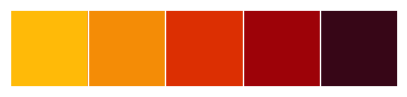

In [125]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#8d99ae"
    PD = "#e63946"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

monocrome_hot = ["#370617","#6a040f","#9d0208","#d00000","#dc2f02","#e85d04","#f48c06","#faa307","#ffba08"]
monochrome_hot_palette = sns.color_palette(palette=monocrome_hot[::-2]) #sns.husl_palette()

sns.palplot(monochrome_palette)


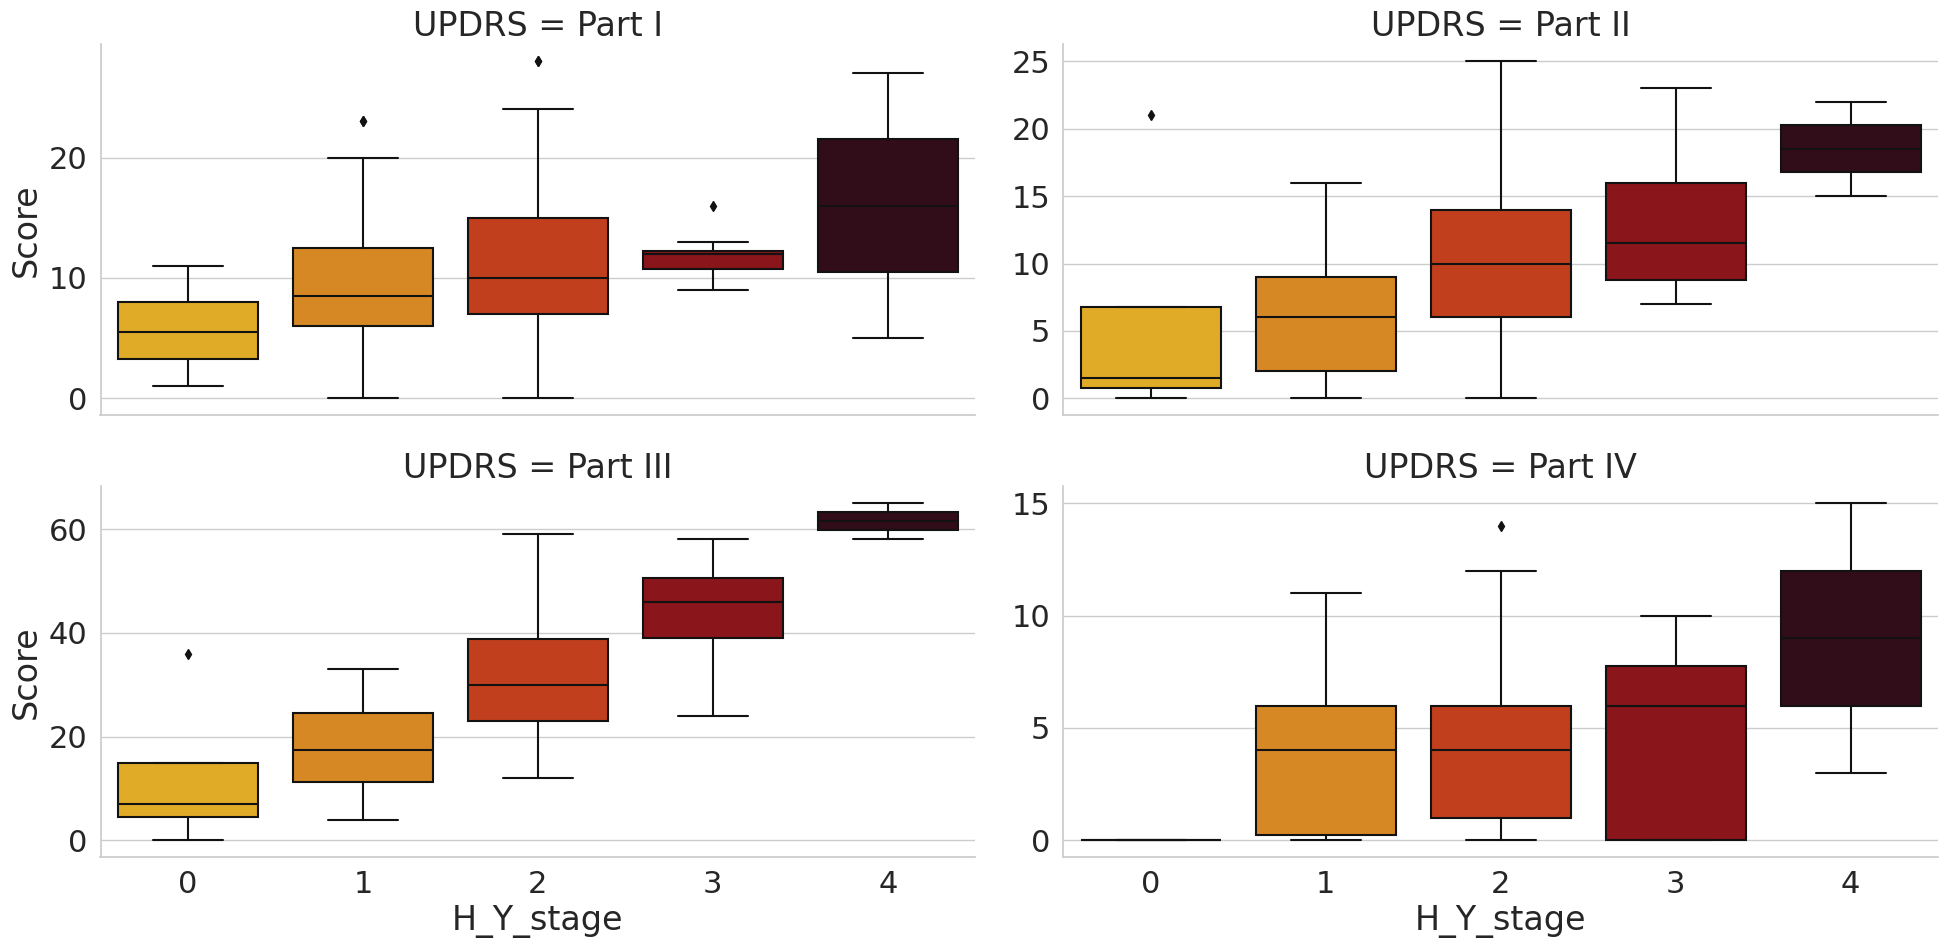

In [142]:
plot_df = pheno_df.copy()

# drop moca
plot_df = plot_df.drop(columns=["moca_scores"])

updrs_cols_dict = {
    "Hoehn and Yahr Stage: ":'H_Y_stage',
    'Part I: Non-Motor Aspects of Experiences of Daily Living (nM-EDL)':'Part I',
    'Part II: Motor Aspects of Experiences of Daily Living (M-EDL)':'Part II',
    'Part III: Motor Examination':'Part III',
    'Part IV: Motor Complications':'Part IV',
}

plot_df = plot_df.rename(columns=updrs_cols_dict)

H_Y_stage_dict = zip(
    [
    '(2) Bilateral involvement without impairment of balance',
    '(3) Bilateral disease: mild to moderate disability with impaired postural reflexes; physically independent; needs assistance to recover from pull test',
    '(1) Unilateral involvement only, usually with minimal or no functional disability',
    '(0) Asymptomatic',
    '(4) Severely disabling disease; still able to walk or stand unassisted',
    np.nan], 
    
    ['2', '3', '1', '0', '4', "N/A"])

H_Y_stage_dict = dict(H_Y_stage_dict)

plot_df["H_Y_stage"] = plot_df["H_Y_stage"].replace(H_Y_stage_dict)
plot_df = plot_df[plot_df["H_Y_stage"]!="N/A"]

plot_df = pd.melt(plot_df, id_vars=["participant_id","redcap_event_name","group","H_Y_stage"], 
                  value_vars=['Part I', 'Part II', 'Part III', 'Part IV'], 
                  var_name="UPDRS", value_name="Score")

plot_df = plot_df[plot_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"]

stage_order = ['0', '1', '2', '3', '4']

sns.set_theme(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="Score",x="H_Y_stage", order=stage_order,
                    col="UPDRS", col_wrap=2, 
                    kind="box", palette=monochrome_hot_palette, 
                    data=plot_df, aspect=2, height=5, sharey=False)
    # g.set_xlabels("")
    # g.set_xticklabels("")

In [139]:
plot_df["group"].value_counts()

group
PD         229
control     78
Unknown     17
Name: count, dtype: int64

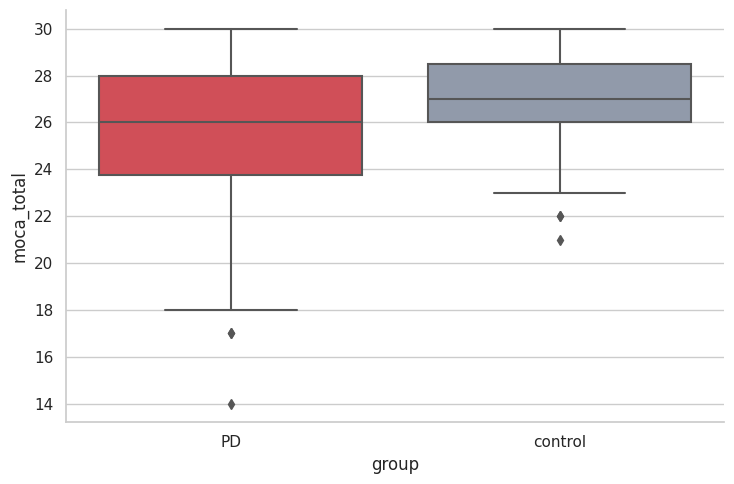

In [153]:
plot_df = pheno_df.copy()

plot_df = plot_df[plot_df["group"].isin(["PD","control"])]

plot_df = plot_df.rename(columns={"moca_scores":"moca_total"})

sns.set_theme(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="moca_total",x="group",
                    kind="box", palette=palette, 
                    data=plot_df, aspect=1.5, height=5, sharey=False)

In [38]:
for dx_group in ["PD", "control"]:
    print(f"*** group: {dx_group} ***")
    dx_df = pheno_df[pheno_df["group"]==dx_group].copy()
    table_df = get_group_table_stats(dx_df, cat_cols, score_cols)
    print("-"*10)
    print(table_df)
    print("-"*10)


*** group: PD ***
Counting 2 and averaging 5
Starting cat cols
Starting score cols
----------
                          redcap_event_name  count    0.0  (0) Asymptomatic  \
0                   Baseline (Arm 1: C-OPN)    204  177.0               4.0   
1  12 Months Follow-Up/Suivi (Arm 1: C-OPN)     19    NaN               NaN   
2  18 Months Follow-Up/Suivi (Arm 1: C-OPN)      6    NaN               NaN   

   (1) Unilateral involvement only, usually with minimal or no functional disability  \
0                                               34.0                                   
1                                                NaN                                   
2                                                NaN                                   

   (2) Bilateral involvement without impairment of balance  \
0                                              101.0         
1                                               10.0         
2                                                2

### Neuropsy scores

In [ ]:
neuropsych_df[neuropsych_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)"].isna().sum().sort_values(ascending=True)[:20]

In [ ]:
index_cols = ["participant_id", "redcap_event_name","group"]
cat_cols = []

# redcap data
if neuropsy_source == "redcap":
    score_cols = [
                    "Trial total 1,2,3 (Raw score)",
                    "Intrusions total 1,2,3 (Raw score)",
                    "Repetitions total 1,2,3 (Raw score)",
                    "Digit Span Forward - total correct (Raw score) ",
                    "Digit span forward - longest correct serie (Raw score)",
                    "Digit Span Backward - total correct (Raw score)",
                    "Digit span backward - longest correct serie (Raw score)  ",    
                    "Command Clock raw (max 10)",
                    "Copy Clock raw (max 10)",
                    "STROOP GOLDEN : WORDS, number of responses",
                    "STROOP GOLDEN : words, self-corrected errors (raw score)",
                    "STROOP GOLDEN, words, uncorrected errors (raw score)",
                    "STROOP GOLDEN : COLORS Number of responses",
                    "STROOP GOLDEN : colors, self-corrected errors (raw scores)",
                    "STROOP GOLDEN: colors, uncorrected errors",
                    "Stroop GOLDEN: INK Number of Responses ",
                    "Stroop GOLDEN : ink, self-corrected errors (raw score)",
                    "Stroop GOLDEN, ink, uncorrected errors (raw score)",
                    "Letter Fluency Total (Raw score)",
                    "Semantic Fluency Total (Automatic Calculation)"
                ]   

# BD_RPQ data
if neuropsy_source == "local":
    score_cols = [
                    "HVLT Trial total 1,2,3 (Raw score)",
                    "Clock Command (Raw score)",
                    "Clock Copy (Raw score)",
                    "Semantic Fluency Total (Raw score)",
                    "RCFT Copy (Raw score)",
                    "Letter Fluency Total (Raw score)",
                    "STROOP GOLDEN : words, self-corrected errors (raw score)",
                    "STROOP GOLDEN : colors, self-corrected errors (raw scores)",
                    "Stroop GOLDEN : ink, self-corrected errors (raw score)",                
                    ]

neuropsy_vars = index_cols + cat_cols + score_cols
neuropsy_df = paper_df[neuropsy_vars]
n_participants = neuropsy_df["participant_id"].nunique()
print(f"Number of participants: {n_participants}")

neuropsy_df.head()

In [ ]:
neuropsy_df[score_cols].isna().sum(axis=0)

In [ ]:
for dx_group in ["PD", "control"]:
    print(f"*** group: {dx_group} ***")
    dx_df = neuropsy_df[neuropsy_df["group"]==dx_group].copy()
    table_df = get_group_table_stats(dx_df, cat_cols, score_cols)
    print("-"*10)
    print(table_df)
    print("-"*10)


### UPDRS legacy and redcap data

In [41]:
updrs3_2019_csv = f"{tabular_data_release_dir}/tabular/recruitment/updrs3_2019.csv"
mds_updrs_hackathon_csv = f"{tabular_data_release_dir}/tabular/recruitment/mds_updrs_hackathon.csv"

updrs3_2019_df = pd.read_csv(updrs3_2019_csv)
mds_updrs_hackathon_df = pd.read_csv(mds_updrs_hackathon_csv)

updrs3_2019_participants = updrs3_2019_df["Record ID:"].unique()
mds_updrs_hackathon_participants = mds_updrs_hackathon_df["Record ID:"].unique()

n_updrs3_2019_participants = len(updrs3_2019_participants)
n_mds_updrs_hackathon_participants = len(mds_updrs_hackathon_participants)

print(f"Number of participants in UPDRS3 2019: {n_updrs3_2019_participants}")
print(f"Number of participants in MDS UPDRS Hackathon: {n_mds_updrs_hackathon_participants}")

Number of participants in UPDRS3 2019: 50
Number of participants in MDS UPDRS Hackathon: 23


In [43]:
updrs_redcap_participants = pheno_var_df[pheno_var_df["Part III: Motor Examination"].notna()]["participant_id"].unique()
print(f"Number of participants with UPDRS data in redcap: {len(updrs_redcap_participants)}")

paper_participants = paper_df["participant_id"].unique()
print(f"Number of participants in paper: {len(paper_participants)}")

updrs_missing_participants = set(paper_participants) - set(updrs_redcap_participants) - set(updrs3_2019_participants) - set(mds_updrs_hackathon_participants)
n_updrs_missing_participants = len(updrs_missing_participants)
print(f"Number of participants missing UPDRS data: {n_updrs_missing_participants}")

Number of participants with UPDRS data in redcap: 155
Number of participants in paper: 287
Number of participants missing UPDRS data: 110


In [48]:
len(list(set(paper_participants) & set(mds_updrs_hackathon_participants)))

18

### Suivi updrs dates

In [56]:
current_recruit_manifest_xls = f"{tabular_data_release_dir}/tabular/recruitment/Suivi_RPQ.xlsx"


col_range = "A:BD"




col_rename_dict = {
    "subj_id":"participant_id",
    "IRM01\n(J-M-A)":"IRM01_date", "#IRM 1\n PD":"IRM01_PD", "#IRM 1\n CTRL":"IRM01_CTRL", 
    "# IRM 1\n RBD":"IRM01_RBD", "# IRM 1\nOTHER":"IRM01_OTHER",
    "IRM 2 \n(J-M-A)":"IRM02_date", "#IRM 2\n PD":"IRM02_PD", "#IRM 2\n CTRL":"IRM02_CTRL", 
    "# IRM 2\n RBD":"IRM02_RBD", "# IRM 2 OTHER":"IRM02_OTHER",
    "IRM 3\n(J-M-A)":"IRM03_date", "#IRM 3\n PD":"IRM03_PD", "#IRM 3\n CTRL":"IRM03_CTRL", 
    "# IRM 3\n RBD":"IRM03_RBD", "# IRM 3 OTHER":"IRM03_OTHER",
    "MDS-UPDRS_partie_III_1\n(J-M-A)":"MDS-UPDRS_III_v01_date", 
    "MDS-UPDRS_complet (J-M-A)": "MDS-UPDRS_complete_date"
    }

useful_cols = col_rename_dict.values()

suivi_df = pd.read_excel(current_recruit_manifest_xls,sheet_name="En cours", engine='openpyxl', usecols=col_range)
suivi_df = suivi_df.rename(columns=col_rename_dict)[useful_cols].copy()

# remove the row with tally
suivi_df = suivi_df.drop([0])

# remove rows without participant_id
suivi_df = suivi_df.dropna(axis=0, subset=["participant_id"])
suivi_df = suivi_df[~suivi_df["participant_id"].astype(str).isin(["0"])] 
suivi_df["participant_id"] = suivi_df["participant_id"].str.strip().astype(str)

# remove subjects without imaging data
suivi_df = suivi_df[(suivi_df["IRM01_PD"] == 1) | (suivi_df["IRM01_CTRL"] == 1) | 
                    (suivi_df["IRM01_RBD"] == 1) | (suivi_df["IRM01_OTHER"] == 1) |
                    (suivi_df["IRM02_PD"] == 1) | (suivi_df["IRM02_CTRL"] == 1) | 
                    (suivi_df["IRM02_RBD"] == 1) |(suivi_df["IRM02_OTHER"] == 1) |
                    (suivi_df["IRM03_PD"] == 1) | (suivi_df["IRM03_CTRL"] == 1) | 
                    (suivi_df["IRM03_RBD"] == 1) |(suivi_df["IRM03_OTHER"] == 1) ]


# fix participant_id formatting issues
# Some rows have Dx in participant_id and one participant with two IDs with "="
possible_delimiters = [" ", "(", "=", "\n"]
for delim in possible_delimiters:        
    suivi_df["participant_id"] = suivi_df["participant_id"].str.strip().str.split(pat=delim, n=1, expand=True)[0]

# nipoppy_participants_current
nipoppy_participants_current = suivi_df["participant_id"].dropna().unique()

suivi_df["MDS-UPDRS_III_v01_date"] = pd.to_datetime(suivi_df["MDS-UPDRS_III_v01_date"], errors="coerce")
suivi_df["MDS-UPDRS_complete_date"] = pd.to_datetime(suivi_df["MDS-UPDRS_complete_date"], errors="coerce")

suivi_df

,participant_id,IRM01_date,IRM01_PD,IRM01_CTRL,IRM01_RBD,IRM01_OTHER,IRM02_date,IRM02_PD,IRM02_CTRL,IRM02_RBD,IRM02_OTHER,IRM03_date,IRM03_PD,IRM03_CTRL,IRM03_RBD,IRM03_OTHER,MDS-UPDRS_III_v01_date,MDS-UPDRS_complete_date
15,PD00016,26-07-2019,1.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaT,NaT
19,PD00020,2018-05-12 00:00:00,1.0,0.0,0.0,NaN,24-11-2022,1,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,2019-05-02,2021-07-23
31,PD00032,24-07-2019,1.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaT,NaT
47,PD00048,21-08-2019,1.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2019-08-21,NaT
117,PD00119,13-08-2018,1.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2018-08-15,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,MNI0565,2023-09-11 00:00:00,0.0,1.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaT,NaT
2231,MNI0602,2023-11-22 00:00:00,1.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2023-11-22,2023-11-22
2234,MNI0605,15-12-2023,0.0,1.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaT,NaT
2236,MNI0607,00:00:00,1.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2023-11-30,2023-11-30


In [68]:
suivi_updrs_participants = suivi_df[(suivi_df["MDS-UPDRS_III_v01_date"].notna() | (suivi_df["MDS-UPDRS_complete_date"].notna()))]["participant_id"]
n_suivi_updrs_participants = len(suivi_updrs_participants)
print(f"Number of participants with UPDRS data in suivi: {n_suivi_updrs_participants}")

Number of participants with UPDRS data in suivi: 214


In [69]:
len(list(set(suivi_updrs_participants) & set(paper_participants)))

203

In [70]:
len(list(set(suivi_updrs_participants) & set(updrs_missing_participants)))

28

In [95]:
missing_updrs_participants_df = pd.DataFrame(list(updrs_missing_participants), columns=["participant_id"])
missing_updrs_participants_df["Suivi_date_present"] = "no"
missing_updrs_participants_df.loc[missing_updrs_participants_df["participant_id"].isin(suivi_updrs_participants),"Suivi_date_present"] = "yes"
missing_updrs_participants_df = pd.merge(missing_updrs_participants_df, demo_df, on="participant_id", how="left")
missing_updrs_participants_df


,participant_id,Suivi_date_present,redcap_event_name,MRI_age,sex,group
0,MNI0421,no,Baseline (Arm 1: C-OPN),54.96,Male,control
1,MNI0224,no,Baseline (Arm 1: C-OPN),76.79,NaN,control
2,MNI0301,no,Baseline (Arm 1: C-OPN),62.13,Female,control
3,PD00016,no,Baseline (Arm 1: C-OPN),55.19,Female,Unknown
4,PD01318,no,Baseline (Arm 1: C-OPN),38.30,Female,control
...,...,...,...,...,...,...
118,PD01314,no,Baseline (Arm 1: C-OPN),55.78,Male,control
119,PD01319,yes,Baseline (Arm 1: C-OPN),66.06,Male,PD
120,MNI0482,no,Baseline (Arm 1: C-OPN),NaN,NaN,Unknown
121,PD01369,yes,Baseline (Arm 1: C-OPN),55.76,Male,PD


In [96]:
missing_updrs_participants_df_PD = missing_updrs_participants_df[
                                                                # (missing_updrs_participants_df["Suivi_date_present"]=="yes") & 
                                                                (missing_updrs_participants_df["group"]=="PD") &
                                                                (missing_updrs_participants_df["redcap_event_name"]=="Baseline (Arm 1: C-OPN)")
                                                                ]
len(missing_updrs_participants_df_PD)


32

In [98]:
missing_updrs_participants_df_PD.reset_index().drop(columns=["index"])

,participant_id,Suivi_date_present,redcap_event_name,MRI_age,sex,group
0,PD00583,yes,Baseline (Arm 1: C-OPN),77.65,Female,PD
1,PD01156,yes,Baseline (Arm 1: C-OPN),82.22,Female,PD
2,PD01306,yes,Baseline (Arm 1: C-OPN),68.12,Male,PD
3,MNI0476,no,Baseline (Arm 1: C-OPN),74.24,Female,PD
4,PD01090,yes,Baseline (Arm 1: C-OPN),68.41,Male,PD
5,PD00668,yes,Baseline (Arm 1: C-OPN),78.21,Male,PD
6,PD01385,yes,Baseline (Arm 1: C-OPN),68.37,Male,PD
7,PD00032,no,Baseline (Arm 1: C-OPN),68.74,Male,PD
8,PD01268,no,Baseline (Arm 1: C-OPN),63.50,Female,PD
9,PD00048,yes,Baseline (Arm 1: C-OPN),75.36,Male,PD


In [92]:
missing_updrs_participants_df_PD.to_csv(f"{tabular_data_release_dir}/tabular/recruitment/missing_updrs_participants_after_hackathon.csv", index=False)